In [1]:
# from fastai.vision import *

from torch.utils.data import Dataset, DataLoader, RandomSampler
from torchvision.models import resnet50
import torch.nn as nn
import torchvision.transforms as transforms
import torch
import torchvision
import torch.nn.functional as F

# from fastai.core import ItemBase
# from fastai.basic_data import DataBunch
from PIL import Image

from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        ### The transfer neural network, without any fully connected layers ###
        self.transfer = resnet50(pretrained=True)
        num_ftrs = self.transfer.fc.in_features
        self.transfer.fc = nn.Linear(num_ftrs, 512)
        
        self.fc1 = nn.Sequential(
            nn.ReLU(inplace=True),
#             nn.Linear(8*100*100, 500),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),

#             nn.Linear(500, 500),
#             nn.ReLU(inplace=True),

            nn.Linear(512, 100))

    def forward_once(self, x):
        output = self.transfer(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

class SiameseDataset(Dataset):
    def __init__(self, data_path, df, same, diff, transforms=None):
        self.c = 1
        self.data_path = data_path
        self.df = df
        self.same_groups = same
        self.diff_groups = diff
        self.transform = transforms
        
    def __len__(self):
        return len(diff)
        
    def __getitem__(self, index):
        ### We will need to draw pairs of similar images as often as dissimilar images ###
        ### This will also function as the label we pass ###
        similar = np.random.choice([0, 1])
        
        ### To draw two dissimilar items ###
        if similar==1:
            ### Draw items from two different objects ###
            ind1, ind2 = np.random.choice(self.diff_groups, size = 2, replace=False)
            
            img1 = np.random.choice(self.df[self.df['Id']==ind1]['Image'].values)
            img2 = np.random.choice(self.df[self.df['Id']==ind2]['Image'].values)

        elif similar==0:
            ind = np.random.choice(self.same_groups)
            
            img1, img2 = np.random.choice(self.df[self.df['Id']==ind]['Image'].values, size=2, replace=False)
        
        img1 = Image.open(self.data_path + img1)
        img2 = Image.open(self.data_path + img2)
        img1 = img1.convert('RGB')
        img2 = img2.convert('RGB')
        
        if self.transform is not None:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, torch.from_numpy(np.array([similar], dtype=np.float32))

SiameseTransforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

We don't want to include the `new_whale` label in training, because we really can't establish if there happen to be any pairs existing in the dataset already.

In [3]:
### Read in a dataframe that contains all images, classes, and their dimensions, created earlier ###
tr = pd.read_csv('../exploratory_analysis/image_dims.csv')

In [4]:
tr = tr[tr['channels']==3]

### Get counts of the various labels, which returns in descending count order ###
wcts = tr['Id'].value_counts()

### Grab everything except for the most numerous, which is the new_whale label ###
nonew = pd.DataFrame(wcts[1:]).reset_index()
nonew.columns = ['Id', 'cts']

### We extract the list of images that can be used as same class and those that cannnot ####
same = nonew[nonew['cts']>1]['Id'].values
diff = nonew[nonew['cts']==1]['Id'].values

same_train, same_val = train_test_split(same, test_size=0.2)
diff_train, diff_val = train_test_split(diff, test_size=0.2)

train_dataset = SiameseDataset('../../train/', tr, same_train, diff_train, transforms=SiameseTransforms)
val_dataset = SiameseDataset('../../train/', tr, same_val, diff_val, transforms=SiameseTransforms)

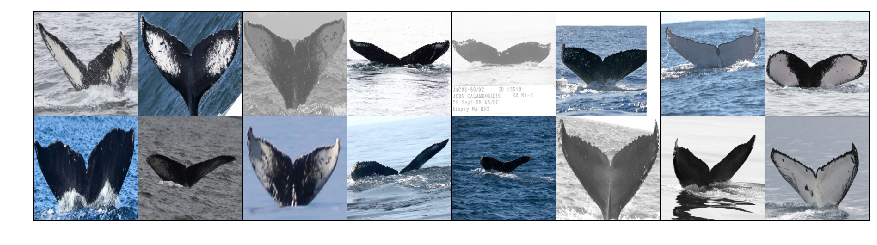

[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [5]:
vis_dataloader = DataLoader(train_dataset,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)

concatenated = torch.cat((example_batch[0],example_batch[1]),0)
plt.figure(figsize=(15,10))
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [6]:
train_dataloader = DataLoader(train_dataset,
                        num_workers=8,
                        batch_size=64)

net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = torch.optim.Adam(net.parameters(),lr = 0.0005 )

counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.0382530689239502

Epoch number 1
 Current loss 0.9932872653007507

Epoch number 2
 Current loss 0.9914551377296448

Epoch number 3
 Current loss 0.9776813983917236

Epoch number 4
 Current loss 0.9663767218589783

Epoch number 5
 Current loss 1.0237534046173096

Epoch number 6
 Current loss 0.9568122029304504

Epoch number 7
 Current loss 0.9708846807479858

Epoch number 8
 Current loss 0.9907568693161011

Epoch number 9
 Current loss 0.9806941747665405

Epoch number 10
 Current loss 0.9613364934921265

Epoch number 11
 Current loss 0.9435020685195923

Epoch number 12
 Current loss 0.9312259554862976

Epoch number 13
 Current loss 0.9270442128181458

Epoch number 14
 Current loss 0.917598307132721

Epoch number 15
 Current loss 0.9065728783607483

Epoch number 16
 Current loss 0.910240650177002

Epoch number 17
 Current loss 0.905605137348175

Epoch number 18
 Current loss 0.9002861380577087

Epoch number 19
 Current loss 0.9039967656135559

Epoch number 

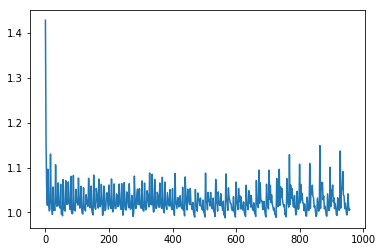

In [7]:
for epoch in range(0,30):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
#         print(img0.size(), img1.size())
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i % 2 == 0 :
#             print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
            iteration_number +=2
    print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
show_plot(counter,loss_history)

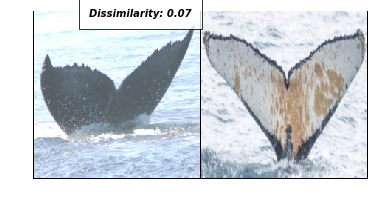

tensor([[1.]], device='cuda:0') 0.0662040114402771


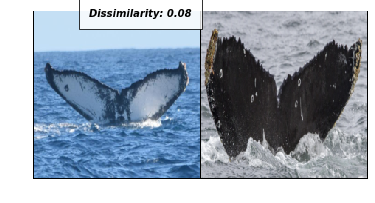

tensor([[1.]], device='cuda:0') 0.07716971635818481


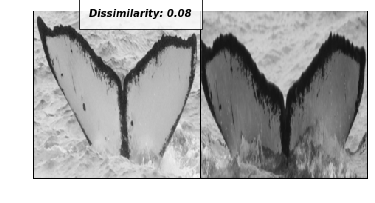

tensor([[0.]], device='cuda:0') 0.07920553535223007


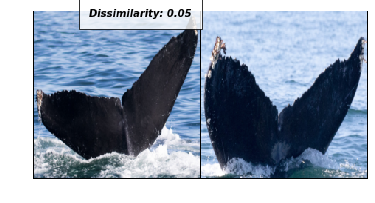

tensor([[0.]], device='cuda:0') 0.04948737099766731


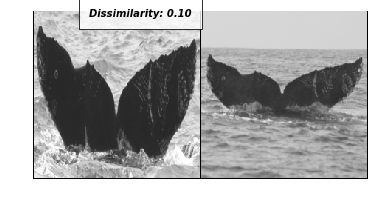

tensor([[0.]], device='cuda:0') 0.096732959151268


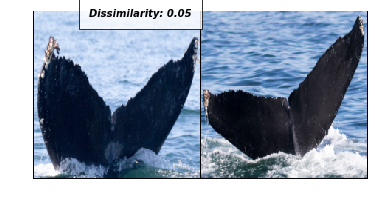

tensor([[0.]], device='cuda:0') 0.04948897659778595


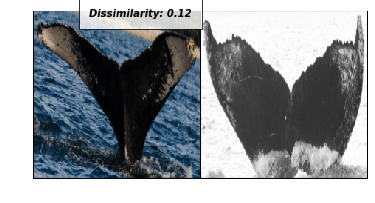

tensor([[0.]], device='cuda:0') 0.11894288659095764


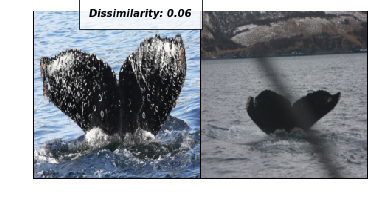

tensor([[1.]], device='cuda:0') 0.06306193768978119


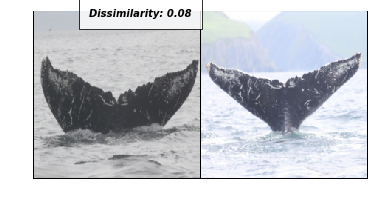

tensor([[0.]], device='cuda:0') 0.07803983986377716


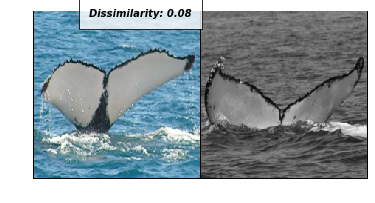

tensor([[1.]], device='cuda:0') 0.08393894881010056


In [8]:
val_dataloader = DataLoader(val_dataset,num_workers=1,batch_size=1,shuffle=True)
dataiter = iter(val_dataloader)

# for i, data in enumerate(val_dataloader,0):
for i in range(10):
    img0, img1 , label = next(dataiter)
    concatenated = torch.cat((img0,img1),0)

    img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
    output1,output2 = net(img0,img1)
    euclidean_distance = F.pairwise_distance(output1, output2)

    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    print(label, euclidean_distance.item())
# for i in range(10):
#     _,x1,label2 = next(dataiter)
#     concatenated = torch.cat((x0,x1),0)
    
#     output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
#     euclidean_distance = F.pairwise_distance(output1, output2)
#     imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

## To Do: 
Will need to define the ability to do transforms, and how to actually use the batch size, etc.

In [ ]:
ImageDataBunch()

In [47]:
train_sampler = RandomSampler(sd)
sdl = SiameseDataLoader('../../train/', tr, same, diff, sampler=train_sampler)

In [48]:
len(sdl)

2073

In [50]:
next(sdl)

TypeError: 'SiameseDataLoader' object is not an iterator

In [14]:
tr.head()

,Image,Id,x,y,channels
0,0000e88ab.jpg,w_f48451c,700,1050,3
1,0001f9222.jpg,w_c3d896a,325,758,3
2,00029d126.jpg,w_20df2c5,497,1050,3
3,00050a15a.jpg,new_whale,525,1050,3
4,0005c1ef8.jpg,new_whale,525,1050,3


In [35]:
np.random.choice(tr[tr['Id']=='w_f48451c']['Image'].values)

'e2f1b6c4a.jpg'

In [37]:
tst1, tst2 = np.random.choice(tr[tr['Id']=='w_f48451c']['Image'].values, size=2)

In [39]:
tst1, tst2

('0000e88ab.jpg', '9fc84d2ae.jpg')

In [58]:
class ImageTuple(ItemBase):
    def __init__(self, img1, img2, similarity_label):
        self.img1,self.img2 = img1,img2
        self.obj,self.data = (img1,img2),[similarity_label]
        
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        return self

In [ ]:
class ImageTupleList(ImageItemList):
    def __init__(self, items, itemsB=None, **kwargs):
        self.itemsB = itemsB
        super().__init__(items, **kwargs)
    
    def new(self, items, **kwargs):
        return super().new(items, itemsB=self.itemsB, **kwargs)
    
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[random.randint(0, len(self.itemsB)-1)]
        return ImageTuple(img1, open_image(fn))
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageItemList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res

    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))

class TargetTupleList(ItemList):
    def reconstruct(self, t:Tensor): 
        if len(t.size()) == 0: return t
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))

class ImageTupleList(ImageItemList):
    _label_cls=TargetTupleList
    def __init__(self, items, itemsB=None, **kwargs):
        self.itemsB = itemsB
        super().__init__(items, **kwargs)
    
    def new(self, items, **kwargs):
        return super().new(items, itemsB=self.itemsB, **kwargs)
    
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[random.randint(0, len(self.itemsB)-1)]
        return ImageTuple(img1, open_image(fn))
    
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageItemList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res

    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)